# **Практика 4: Атака `DeepFool` на модели ИИ**

По предмету: **Анализ защищенности систем искусственного интеллекта**

Выполнил студент **2 курса** группы **ББМО-02-23**

**Карпейкин Владислав Анатольевич**

##**Цель задания:**
Изучить атаку `DeepFool`, которая предназначена для минимальных изменений в изображениях с целью изменения их классификации. Научиться использовать эту атаку и исследовать влияние противоречивых примеров на обученные модели

##**Задачи:**
1. Загрузить ранее обученную модель на датасете `MNIST`;
2. Изучить теоретические основы атаки `DeepFool`;
3. Реализовать атаку `DeepFool` с помощью фреймворка `Foolbox`;
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

##**Шаги выполнения:**

###**Шаг 1: Загрузка обученной модели и данных MNIST**

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST:
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot:
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели:
model = tf.keras.models.load_model('/content/mnist_model.h5')
# Проверка точности модели на обычных данных:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9752 - loss: 0.0817
Test accuracy on clean images: 0.9778000116348267


### Шаг 2: Теория атаки `DeepFool`

Атака `DeepFool` — это метод, который был разработан для минимального изменения изображений с целью заставить классификационную модель ошибиться. В отличие от других атак, таких как `FGSM`, `DeepFool` находит минимальные изменения в пространстве признаков, которые достаточны для изменения предсказания модели. Это делает `DeepFool` более эффективной в создании противоречивых примеров с минимальным изменением входных данных

### Шаг 3: Реализация атаки `DeepFool` с использованием `Foolbox`

 Для выполнения атаки `DeepFool` мы будем использовать библиотеку `Foolbox`, которая поддерживает различные атаки на модели ИИ, включая `DeepFool`.

Установка `Foolbox`:

In [3]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.9 MB/s eta 0:00:00


Реализация атаки `DeepFool`:

Как пример атака происходит на первые 5 изображений:

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


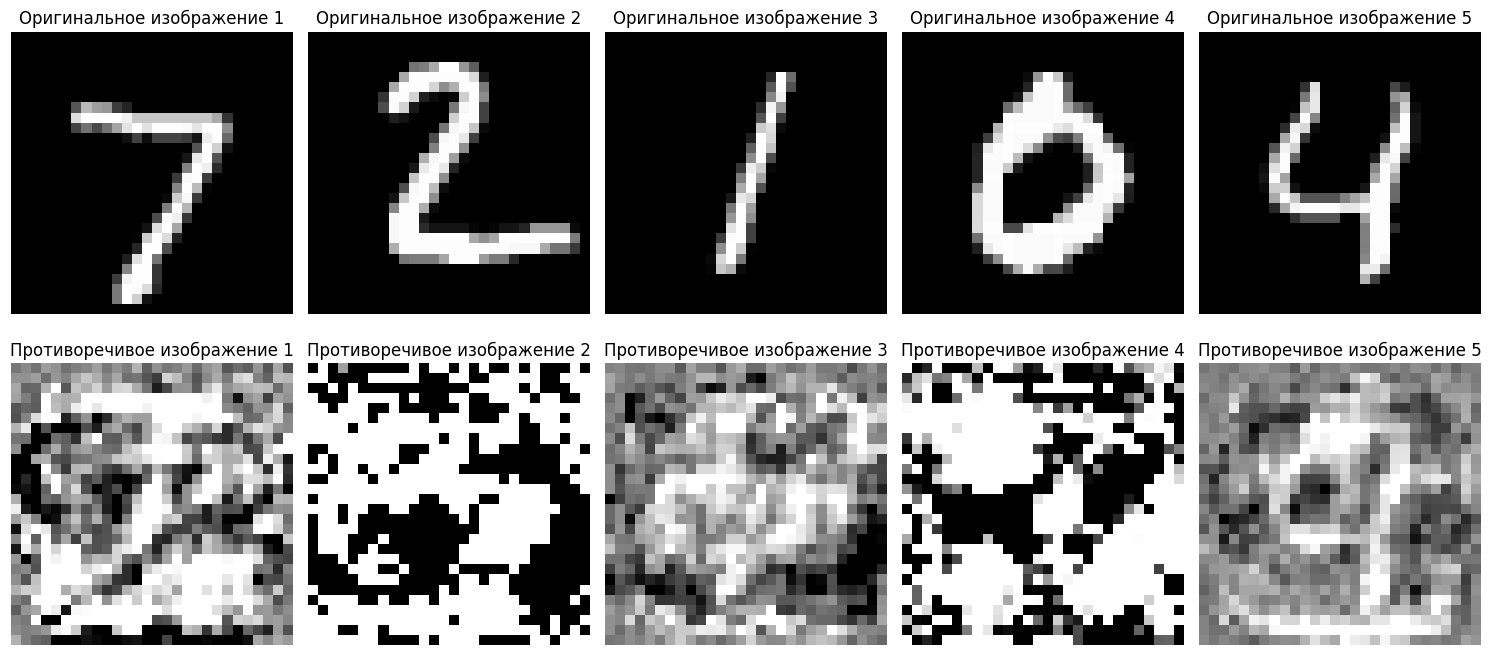

In [4]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  # Убедитесь, что TensorFlow импортирован

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Создание атаки DeepFool
attack = fb.attacks.L2DeepFoolAttack(steps=100)

# Количество изображений для атаки
num_images = 5

# Создание подграфиков для отображения результатов
plt.figure(figsize=(15, 7))

for i in range(num_images):
    # Выбор изображения для атаки
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)

    # Выполнение атаки
    adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.01)

    # Отображение оригинального и противоречивого изображений
    plt.subplot(2, num_images, i + 1)
    plt.title(f"Оригинальное изображение {i+1}")
    plt.imshow(image[0].numpy(), cmap="gray")
    plt.axis('off')

    plt.subplot(2, num_images, num_images + i + 1)
    plt.title(f"Противоречивое изображение {i+1}")
    plt.imshow(adversarial_image[0].numpy(), cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Шаг 4: Оценка модели на противоречивых примерах

 Теперь мы проверим, насколько сильно атака `DeepFool` влияет на точность модели. Мы создадим набор противоречивых примеров и оценим производительность модели на этих данных.

In [10]:
import tensorflow as tf
import numpy as np

batch_size = 32
num_batches = len(test_images) // batch_size + (1 if len(test_images) % batch_size != 0 else 0)
adversarial_images = []
adversarial_labels = []

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(test_images))

    images_batch = tf.convert_to_tensor(test_images[start_idx:end_idx], dtype=tf.float32)
    labels_batch = np.argmax(test_labels[start_idx:end_idx], axis=1)
    labels_batch = tf.convert_to_tensor(labels_batch, dtype=tf.int64)


    advs_batch, _, success_batch = attack(fmodel, images_batch, labels_batch, epsilons=0.01)


    if tf.reduce_any(success_batch):
        adversarial_images.append(advs_batch)
        adversarial_labels.append(labels_batch)

adversarial_images = tf.concat(adversarial_images, axis=0)
adversarial_labels = tf.concat(adversarial_labels, axis=0)

num_classes = model.output_shape[-1]
adversarial_labels = tf.one_hot(adversarial_labels, depth=num_classes)


adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, adversarial_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 137.9225
Accuracy on adversarial examples (DeepFool): 0.0


### Шаг 5: Сравнение результатов

Точность модели на примерах, подвергнутых атакам, составляет примерно 0%. Это резкое снижение эффективности может быть связано с тем, что модель оказывается крайне чувствительной к незначительным, но тщательно подобранным изменениям в изображениях, созданным с целью обмана системы. Небольшие модификации, как в случае атаки `DeepFool`, способны значительно сбивать модель с толку.

Такое снижение точности указывает на потенциальную слабость модели в плане устойчивости к внешним воздействиям. В реальных приложениях, где изображения могут подвергаться различным помехам или манипуляциям, модель с подобной уязвимостью может не вызывать доверия. Например, в системах безопасности или автономных транспортных средствах такие слабости могут быть использованы для манипуляции результатами распознавания объектов или дорожных знаков.

**Вывод:**
Снижение точности на атакованных примерах подчеркивает необходимость учитывать устойчивость модели к атакам, что особенно важно для её применения в реальных и потенциально враждебных условиях.